In [1]:
import numpy as np 
from astropy.io import fits 
from smooth_kevin import smoother
import py_specrebin
import matplotlib.pyplot as plt 
from matplotlib import rc
path_name = '.'

# assuming we have arrays called (of the same size):
# wave,flux,flux_err
# and a new wavelength that we want to interpolate onto, called new_wave
# new_flux,new_ivar = py_specrebin.rebinspec(wave,flux,new_wave,ivar=np.power(flux_err,-2))
# new_flux_err = 1/np.sqrt(new_ivar)

# import py_specrebin
# assuming we have arrays called (of the same size):
# wave,flux
# and a new wavelength that we want to interpolate onto, called new_wave
# new_flux = py_specrebin.rebinspec(wave,flux,new_wave)

In [2]:
def make_plot(file_name, sigma, plot_name):
    #read in star data
    h_star = fits.open(path_name + '/' + file_name)
    data_star1 = h_star[1].data
    star_flux1 = data_star1['SKYSPEC'][0]
    star_wave1 = data_star1['LAMBDA'][0]
    star_ivar1 = data_star1['IVAR'][0]
    data_star2 = h_star[2].data
    star_flux2 = data_star2['SKYSPEC'][0]
    star_wave2 = data_star2['LAMBDA'][0]
    star_ivar2 = data_star2['IVAR'][0]
    
    #combine the blue and red side into one list
    star_flux = np.array(list(star_flux1) + list(star_flux2))
    star_wave = np.array(list(star_wave1) + list(star_wave2))
    star_ivar = np.array(list(star_ivar1) + list(star_ivar2))
    
    #smooth spectrum
    smooth_star = smoother(star_wave, star_flux, star_ivar, sigma=sigma)
    
    #normalize spectrum
    med_cont = np.nanmedian(smooth_star)
    smooth_star /= med_cont
    
    #remove telluric features at 7600 and 6900
    remove_telluric1 = (star_wave < 6830) 
    remove_telluric2 = (star_wave > 7700) 
    remove_telluric3 = ((star_wave > 6950) & (star_wave < 7580))
    
    #plot the data
    plt.plot(star_wave[remove_telluric1], smooth_star[remove_telluric1], c='b')
    plt.plot(star_wave[remove_telluric2], smooth_star[remove_telluric2], c='b')
    plt.plot(star_wave[remove_telluric3], smooth_star[remove_telluric3], c='b')
    plt.savefig(plot_name, bbox_inches='tight', dpi=200)
    plt.close()

In [3]:
def lambda_a_minus_lambda_b(spectra_1):
    #find the difference between wavelength a and wavelength b 
    lamb_a_lamb_b = spectra_1[0] - spectra_1[1]
    
    #plot the differences as a histogram
    plt.figure()
    plt.title("Lambda (B) - Lambda (A)")
    plt.xlabel("Wavelength Difference")
    plt.ylabel("Frequency")
    plt.hist(lamb_a_lamb_b,bins = 100)

In [4]:
def dif_between_lambda(spectra_2):
    list_of_dif = []
    #create a for loop to produce to subtract the wavelength from each other
    for i in range(len(spectra_2)-1):
        difference = spectra_2[i+1] - spectra_2[i]
        list_of_dif.append(difference)
    
    #plot the wavelength differences as a histogram 
    plt.figure()
    plt.title("Lambda(i+1) - Lambda(i)")
    plt.xlabel("Wavelength Difference")
    plt.ylabel("Frequency")
    plt.hist(list_of_dif,bins=30)

In [5]:
#array from 4000 to 10000 spaced by 0.25
new_wave_array = np.array(np.linspace(4000,10000,24000))

In [6]:
def make_ladder_plot(file_name, rung, sigma, plot_name):
    color=['black','dimgray','gray','darkgray','silver','black']
    i = 0
    list_of_star_wave1 = []
    list_of_star_wave2 = []
    list_of_star_flux1 = []
    list_of_star_ivar1 = []
    for j in range(len(file_name)):
        #read in star data
        h_star = fits.open(path_name + '/' + file_name[j])
        data_star1 = h_star[1].data
        star_flux1 = data_star1['SKYSPEC'][0]
        star_wave1 = data_star1['LAMBDA'][0]
        star_ivar1 = data_star1['IVAR'][0]
        data_star2 = h_star[2].data
        star_flux2 = data_star2['SKYSPEC'][0]
        star_wave2 = data_star2['LAMBDA'][0]
        star_ivar2 = data_star2['IVAR'][0]
        
        #add star_wave1 into a list
        list_of_star_wave1.append(star_wave1)
        list_of_star_flux1.append(star_flux1)
        list_of_star_ivar1.append(star_ivar1)
        
        #add star_wave2 into a list
        list_of_star_wave2.append(star_wave2)
        
        #combine the blue and red side into one list
        star_flux = np.array(list(star_flux1) + list(star_flux2))
        star_wave = np.array(list(star_wave1) + list(star_wave2))
        star_ivar = np.array(list(star_ivar1) + list(star_ivar2))
        
        #smooth spectrum
        smooth_star = smoother(star_wave, star_flux, star_ivar, sigma=sigma[j])
        
        #normalize spectrum
        med_cont = np.nanmedian(smooth_star)
        smooth_star /= med_cont
        smooth_star += i*rung
        i += 1
        
        #remove telluric features at 7600 and 6900
        remove_telluric1 = (star_wave < 6830) 
        remove_telluric2 = (star_wave > 7700) 
        remove_telluric3 = ((star_wave > 6950) & (star_wave < 7580))
    
        #plot the data
        plt.plot(star_wave[remove_telluric1], smooth_star[remove_telluric1],c=color[j])
        plt.plot(star_wave[remove_telluric2], smooth_star[remove_telluric2],c=color[j])
        plt.plot(star_wave[remove_telluric3], smooth_star[remove_telluric3],c=color[j]) 
    plt.savefig(plot_name, bbox_inches='tight', dpi=200)
    plt.close()
    
    #return the list_of_star_wave1 so we can use it
    return list_of_star_wave1, list_of_star_wave2, list_of_star_flux1, list_of_star_ivar1

In [7]:
def format_plot():#h_features, h_positions, v_features, v_positions):
    #style stuff
    rc('font', family = 'serif')
    fig, ax=plt.subplots(1, figsize=(16,8))
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1)
    ax.tick_params(axis='x',which='both',bottom='on',top='on', direction='out')
    ax.tick_params(axis='x',which='both',top='on', direction='in')
    ax.tick_params(axis='y',which='both',left='on',top='off', direction='out')
    ax.tick_params(axis='y',which='both',right='on', direction='in')
    plt.tick_params(which='both', width=1)
    plt.tick_params(which='major', length=7)
    plt.tick_params(which='minor', length=4)
    plt.tick_params(labelsize=19) 
    plt.minorticks_on()
    
    #mark spectral lines
    plt.plot([6563,6563],[-50,50],c='red',label=r"H$\alpha$ 6563$\rm\AA$")
    plt.plot([5876,5876],[-50,50],c='purple',label=r"He I 5876$\rm\AA$")
    plt.plot([6678,6678],[-50,50],c='purple',label=r"He I 6678$\rm\AA$")
    plt.plot([7065,7065],[-50,50],c='purple',label=r"He I 7065$\rm\AA$")
    plt.legend(loc=0, fontsize=10)
    
    #axes
    plt.xlim(4500, 9600)
    #plt.xlim(6400, 6700)
    plt.ylim(0,7)
    #plt.ylim(4.5,5.5)
    plt.xlabel(r'$\rm Wavelength\ [\AA]$', fontsize=19)
    plt.ylabel(r'$\rm Relative\ Flux\ [electrons\ hr^{-1}]$', fontsize=19)
    
    #annotations
#     for i in range(len(h_features)):
#         ax.annotate(h_features[i], xy=(h_positions[i][0], h_positions[i][1]), fontsize=19, ha='center')
#     for i in range(len(v_features)):
#         ax.annotate(v_features[i], xy=(v_positions[i][0], v_positions[i][1]), fontsize=19, ha='center', rotation=90)

In [8]:
#make plots!
#the first list here should contain the names of features;
#the second list should have the xy coordinates of where you want the label to go
#APID 1018 -- example
#format_plot(['CN', 'Telluric'], [[8000, 370], [9500, 200]], ['Telluric', 'Telluric'], [[6880, 410], [7650, 1000]]) 
format_plot() 
#make_plot('spec1d.C1M33P.161.MS_301405.fits.gz', 0.2, 'MS_301405_smooth_spec.png')
#file_names = ['spec1d.C1M33P.101.MS_180497.fits.gz','spec1d.C1M33P.160.MS_287502.fits.gz','spec1d.C1M33P.164.MS_323338.fits.gz','spec1d.C2M33P.104.MS_180458.fits.gz','spec1d.E2M33P.085.MS_2328.fits.gz','comp_spec1d.fits.gz']
file_names = ['spec1d.C1M33P.101.MS_180497.fits.gz','spec1d.C1M33P.160.MS_287502.fits.gz','spec1d.C1M33P.164.MS_323338.fits.gz','spec1d.C2M33P.104.MS_180458.fits.gz','spec1d.E2M33P.085.MS_2328.fits.gz','spec1d.E2M33P.034.CFHT258885.fits.gz']
#file_names = ['spec1d.C1M33P.000.KG268.fits.gz','spec1d.C1M33P.161.MS_301405.fits.gz']
smooth_array = [1, 1, 0.5, 0.5, 0.5, 1]

#call_1 now contain a list of all star_wave1
#call_2 now contain a list of all star_wave2
#call_3 now contain a list of all star_flux1
#call_4 now contain a list of all star_ivar1
call_1,call_2,call_3,call_4 = make_ladder_plot(file_names, 0.9, smooth_array, 'testing_image.png')

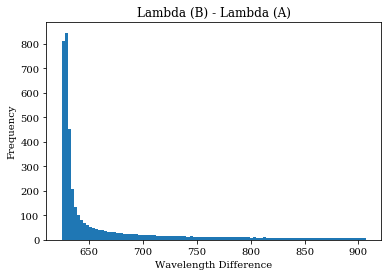

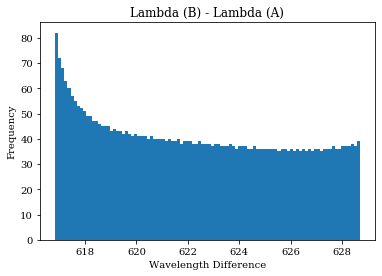

In [9]:
#call the function and provide the spectra to find lambda(A) - lambda (B) for star_wave1
lambda_a_minus_lambda_b(call_1)
#call the function and provide the spectra to find lambda(A) - lambda (B) for star_wave2
lambda_a_minus_lambda_b(call_2)

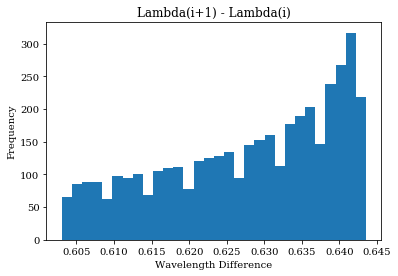

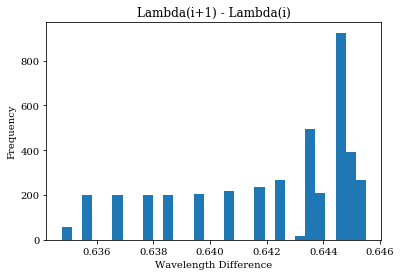

In [10]:
#call the function and provide the spectra to find lambda(i+1) - lambda(i) for star_wave1
dif_between_lambda(call_1[0])
#call the function and provide the spectra to find lambda(i+1) - lambda(i) for star_wave2
dif_between_lambda(call_2[0])

In [13]:
#rebinning function 
def rebinning(wave,flux,new_wave):
    import py_specrebin
    #assuming we have arrays called (of the same size):
    #wave,flux
    #and a new wavelength that we want to interpolate onto, called new_wave
    new_flux = py_specrebin.rebinspec(wave,flux,new_wave)
    print(new_flux)

In [14]:
#call the rebinning function and provide the necessary arguments 
rebinning(call_1[0],call_3[0],new_wave_array)

[nan nan nan ... nan nan nan]


In [ ]:
def rebinning(wave,flux,new_wave,ivar):
    import py_specrebin
    #assuming we have arrays called (of the same size):
    #wave,flux
    #and a new wavelength that we want to interpolate onto, called new_wave
    new_flux,new_ivar = py_specrebin.rebinspec(wave,flux,new_wave,ivar)
    new_flux_err = 1/np.sqrt(new_ivar)

In [ ]:
#call the rebinning function and provide the necessary arguments 
rebinning(call_1[0],call_3[0],new_wave_array,call_4[0])